In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf 
import ta  

In [32]:
# 데이터 불러오기 (2013년부터 2023년까지 훈련 데이터, 2024년 1월부터 4월까지 테스트 데이터)
train_data = yf.download('AAPL', start='2013-01-01', end='2024-01-01')
test_data = yf.download('AAPL', start='2024-01-01', end='2024-05-01')

# 데이터 전처리 및 피처 엔지니어링
for data in [train_data, test_data]:
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['RSI'] = ta.momentum.RSIIndicator(data['Close'].iloc[:, 0]).rsi()
    data.dropna(inplace=True)

# 피처와 타깃 변수 설정
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'RSI']

X_train = train_data[features].values
y_train = (train_data['Close'].shift(-1) > train_data['Close']).astype(int).values[:-1]
X_train = X_train[:-1]

X_test = test_data[features].values
y_test = (test_data['Close'].shift(-1) > test_data['Close']).astype(int).values[:-1]
X_test = X_test[:-1]

# 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [33]:
# 트랜스포머 모델 정의
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # 멀티헤드 어텐션
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # 피드포워드 네트워크
    x = tf.keras.layers.Dense(ff_dim, activation="relu")(res)
    x = tf.keras.layers.Dense(inputs.shape[-1])(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [34]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.Flatten()(x)
    for dim in mlp_units:
        x = tf.keras.layers.Dense(dim, activation="relu")(x)
        x = tf.keras.layers.Dropout(mlp_dropout)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(inputs, outputs)

In [35]:
# 모델 생성
input_shape = (X_train.shape[1], 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 7, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 1)      │      7,169 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 1)      │          2 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 7, 1)      │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 7, 4)      │          8 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 7, 1)      │          5 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 1)      │          2 │ dense_11[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 7, 1)      │          0 │ layer_normalizat… │
│                     │                   │            │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 1)      │      7,169 │ add_9[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 1)      │          2 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 7, 1)      │          0 │ layer_normalizat… │
│                     │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 7, 4)      │          8 │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 7, 1)      │          5 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 1)      │          2 │ dense_13[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 7, 1)      │          0 │ layer_normalizat… │
│                     │                   │            │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 1)      │      7,169 │ add_11[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_11[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 1)      │          2 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 7, 1)      │          0 │ layer_normalizat… │
│                     │                   │            │ add_11[0][0]    

 Total params: 29,897 (116.79 KB)

 Trainable params: 29,897 (116.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4608 - loss: 0.7119 - val_accuracy: 0.4809 - val_loss: 0.7019
Epoch 2/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5010 - loss: 0.6991 - val_accuracy: 0.4809 - val_loss: 0.6975
Epoch 3/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4920 - loss: 0.7003 - val_accuracy: 0.4846 - val_loss: 0.6942
Epoch 4/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4881 - loss: 0.6982 - val_accuracy: 0.4719 - val_loss: 0.6930
Epoch 5/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5126 - loss: 0.6983 - val_accuracy: 0.5318 - val_loss: 0.6925
Epoch 6/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4995 - loss: 0.6982 - val_accuracy: 0.5227 - val_loss: 0.6923
Epoch 7/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5296 - loss: 0.6944 - val_accuracy: 0.5209 - val_loss: 0.6922
Epoch 8/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5069 - loss: 0.7003 - val_accuracy: 0.52

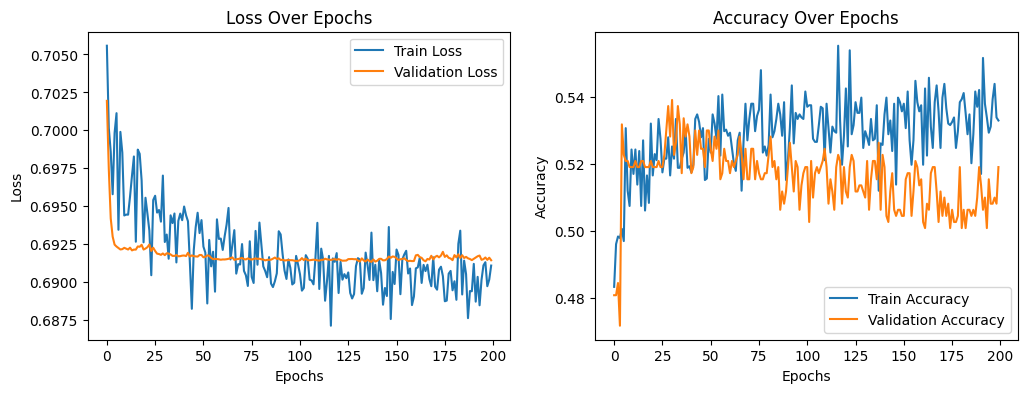

In [36]:
# 모델 학습 (에포크 수 증가)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=32)

# 학습 곡선 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [37]:

# 훈련 데이터 결과
y_train_pred = model.predict(X_train)
threshold = y_train.mean()  # 훈련 데이터 비율로 트레시홀드 설정
y_train_pred_threshold = (y_train_pred > threshold).astype(int)
accuracy_train = accuracy_score(y_train, y_train_pred_threshold)
conf_matrix_train = confusion_matrix(y_train, y_train_pred_threshold)
print(f"훈련 데이터 정확도: {accuracy_train:.2f}")
print("훈련 데이터 혼동 행렬:")
print(conf_matrix_train)
print("\n훈련 데이터 분류 리포트:")
print(classification_report(y_train, y_train_pred_threshold))


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
훈련 데이터 정확도: 0.53
훈련 데이터 혼동 행렬:
[[702 599]
 [686 767]]

훈련 데이터 분류 리포트:
              precision    recall  f1-score   support

           0       0.51      0.54      0.52      1301
           1       0.56      0.53      0.54      1453

    accuracy                           0.53      2754
   macro avg       0.53      0.53      0.53      2754
weighted avg       0.54      0.53      0.53      2754



In [38]:

# 테스트 데이터 결과
y_pred = model.predict(X_test)
y_pred_threshold = (y_pred > threshold).astype(int)
accuracy_test = accuracy_score(y_test, y_pred_threshold)
conf_matrix_test = confusion_matrix(y_test, y_pred_threshold)
print(f"테스트 데이터 정확도: {accuracy_test:.2f}")
print("테스트 데이터 혼동 행렬:")
print(conf_matrix_test)
print("\n테스트 데이터 분류 리포트:")
print(classification_report(y_test, y_pred_threshold))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
테스트 데이터 정확도: 0.65
테스트 데이터 혼동 행렬:
[[26 15]
 [ 9 19]]

테스트 데이터 분류 리포트:
              precision    recall  f1-score   support

           0       0.74      0.63      0.68        41
           1       0.56      0.68      0.61        28

    accuracy                           0.65        69
   macro avg       0.65      0.66      0.65        69
weighted avg       0.67      0.65      0.66        69



In [27]:
# 훈련 데이터와 테스트 데이터의 클래스 분포 확인
print("훈련 데이터 클래스 분포:")
print(pd.Series(y_train).value_counts())
print("\n테스트 데이터 클래스 분포:")
print(pd.Series(y_test).value_counts())


훈련 데이터 클래스 분포:
1    1448
0    1306
Name: count, dtype: int64

테스트 데이터 클래스 분포:
0    41
1    28
Name: count, dtype: int64
